In [1]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

zip_path = r"C:\Users\Tayna Appel\Downloads\archive.zip"
extract_dir = "/mnt/data/supplement_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
extracted_files


['Supplement_Sales_Weekly_Expanded.csv']

In [2]:
supplement_df = pd.read_csv(os.path.join(extract_dir, 'Supplement_Sales_Weekly_Expanded.csv'))

supplement_df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [3]:
supplement_df.describe

<bound method NDFrame.describe of             Date        Product Name     Category  Units Sold  Price  Revenue  \
0     2020-01-06        Whey Protein      Protein         143  31.98  4573.14   
1     2020-01-06           Vitamin C      Vitamin         139  42.51  5908.89   
2     2020-01-06            Fish Oil        Omega         161  12.91  2078.51   
3     2020-01-06        Multivitamin      Vitamin         140  16.07  2249.80   
4     2020-01-06         Pre-Workout  Performance         157  35.47  5568.79   
...          ...                 ...          ...         ...    ...      ...   
4379  2025-03-31           Melatonin    Sleep Aid         160  47.79  7646.40   
4380  2025-03-31              Biotin      Vitamin         154  38.12  5870.48   
4381  2025-03-31   Green Tea Extract   Fat Burner         139  20.40  2835.60   
4382  2025-03-31     Iron Supplement      Mineral         154  18.31  2819.74   
4383  2025-03-31  Electrolyte Powder    Hydration         178  39.12  6963.

In [5]:
df = supplement_df.copy()


In [6]:
df["treatment_group"] = (df["Platform"] == "iHerb").astype(int)


In [7]:
df["post_treatment"] = (df["Date"] >= "2023-01-01").astype(int)

In [8]:
df["interaction"] = df["treatment_group"] * df["post_treatment"]

In [9]:
df[["Platform", "Date", "treatment_group", "post_treatment", "interaction"]].head()


,Platform,Date,treatment_group,post_treatment,interaction
0,Walmart,2020-01-06,0,0,0
1,Amazon,2020-01-06,0,0,0
2,Amazon,2020-01-06,0,0,0
3,Walmart,2020-01-06,0,0,0
4,iHerb,2020-01-06,1,0,0


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#DiD Model
model = smf.ols('Revenue ~ treatment_group + post_treatment + interaction', data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2313
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.875
Time:                        08:21:28   Log-Likelihood:                -39945.
No. Observations:                4384   AIC:                         7.990e+04
Df Residuals:                    4380   BIC:                         7.992e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5199.9611     54.154     96.022      0.000    5093.792    5306.130
treatment_group    13.2559     92.473      0.143      0.886    -168.038     194.550
post_treatment     45.0857     82.436      0.547      0.584    -116.531     206.703
interaction        18.1317    141.047      0.129      0.898    -258.392     294.655
==============================================================================
Omnibus:                     1061.245   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.030
Skew:                           0.119   Prob(JB):                     1.64e-43
Kurtosis:                       1.989   Cond. No.                         6.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
df["Date"] = pd.to_datetime(df["Date"])


In [48]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week
df["DayOfWeek"] = df["Date"].dt.dayofweek

In [49]:
features = ["Category", "Price", "Discount", "Location", "Platform", "Month", "Week", "DayOfWeek"]
target = "Units Sold"


In [50]:
df_model = df[features + [target]].dropna()


In [51]:
df_encoded = pd.get_dummies(df_model, columns=["Category", "Location", "Platform"], drop_first=True)


In [52]:
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(random_state=2)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=2)

In [55]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

(mae, r2)

(10.259942987457242, -0.08452273303877922)

In [56]:
df_did = supplement_df.copy()

In [57]:
df_did["Date"] = pd.to_datetime(df_did["Date"])

In [58]:
df_did = df_did[df_did["Category"].isin(["Protein", "Vitamin"])] #chosen protein as treatment and vitamines as control

In [59]:
cutoff_date = df_did["Date"].median() #split in before and after trhough the median

In [60]:
df_did["post_treatment"] = (df_did["Date"] > cutoff_date).astype(int)

In [62]:
df_did["treatment_group"] = (df_did["Category"] == "Protein").astype(int)

In [63]:
df_did["Revenue"] = pd.to_numeric(df_did["Revenue"], errors='coerce')

In [64]:
df_did["interaction"] = df_did["post_treatment"] * df_did["treatment_group"]


In [65]:
did_data = df_did[["Date", "Category", "Revenue", "post_treatment", "treatment_group", "interaction"]]

In [66]:
did_data

,Date,Category,Revenue,post_treatment,treatment_group,interaction
0,2020-01-06,Protein,4573.14,0,1,0
1,2020-01-06,Vitamin,5908.89,0,0,0
3,2020-01-06,Vitamin,2249.80,0,0,0
8,2020-01-06,Protein,1611.12,0,1,0
12,2020-01-06,Vitamin,4577.61,0,0,0
...,...,...,...,...,...,...
4368,2025-03-31,Protein,2245.16,1,1,1
4369,2025-03-31,Vitamin,8961.56,1,0,0
4371,2025-03-31,Vitamin,1675.52,1,0,0
4376,2025-03-31,Protein,7707.34,1,1,1


In [67]:
supplement_df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [68]:
import statsmodels.formula.api as smf
model_amz = smf.ols("Revenue ~ treatment_group + post_treatment + interaction", data=did_data).fit()
model_amz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5210
Date:                Tue, 24 Jun 2025   Prob (F-statistic):              0.668
Time:                        17:12:02   Log-Likelihood:                -12485.
No. Observations:                1370   AIC:                         2.498e+04
Df Residuals:                    1366   BIC:                         2.500e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5249.6364    108.459     48.402      0.000    5036.873    5462.400
treatment_group  -153.0604    171.488     -0.893      0.372    -489.469     183.348
post_treatment    -36.4389    153.383     -0.238      0.812    -337.332     264.454
interaction       264.7909    242.521      1.092      0.275    -210.962     740.544
==============================================================================
Omnibus:                      292.908   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.766
Skew:                           0.121   Prob(JB):                     1.05e-13
Kurtosis:                       2.006   Cond. No.                         6.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

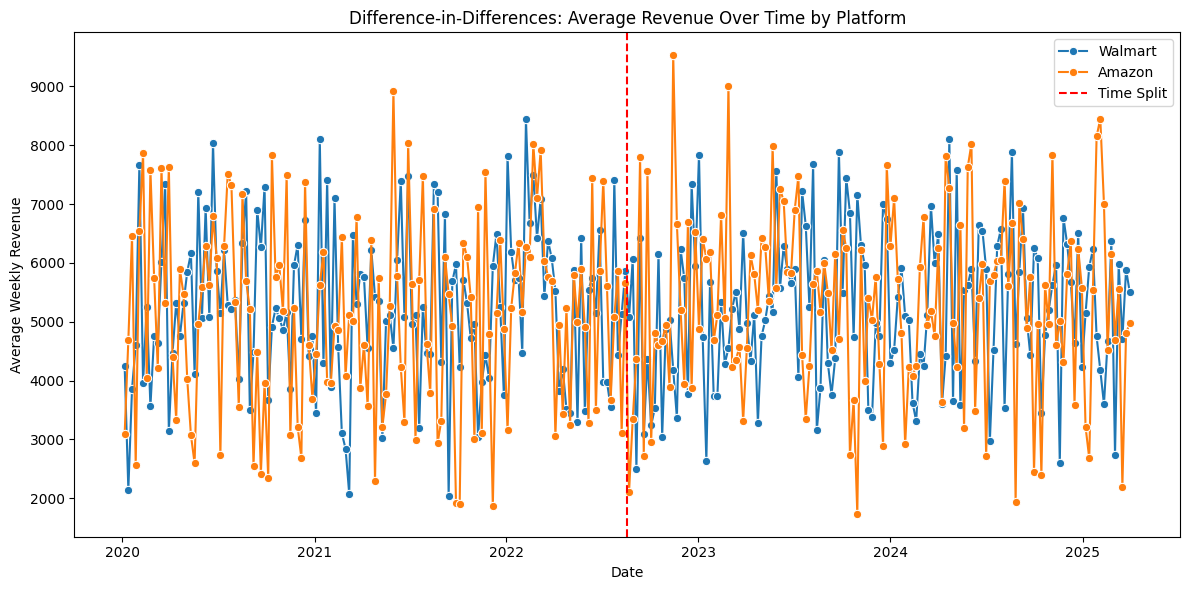

In [69]:
avg_revenue = did_data.groupby(["Date", "treatment_group"])["Revenue"].mean().reset_index()
avg_revenue["Platform"] = avg_revenue["treatment_group"].map({1: "Amazon", 0: "Walmart"})

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_revenue, x="Date", y="Revenue", hue="Platform", marker="o")
plt.axvline(cutoff_date, color="red", linestyle="--", label="Time Split")
plt.title("Difference-in-Differences: Average Revenue Over Time by Platform")
plt.xlabel("Date")
plt.ylabel("Average Weekly Revenue")
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
pip install causalml


Defaulting to user installation because normal site-packages is not writeable
  Using cached causalml-0.15.4.tar.gz (1.9 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached forestci-0.6-py3-none-any.whl.metadata (1.3 kB)
  Using cached pathos-0.2.9-py3-none-any.whl.metadata (11 kB)
  Using cached cython-3.1.2-cp313-cp313-win_amd64.whl.metadata (6.0 kB)
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached shap-0.48.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metada

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [304 lines of output]
  C:\Users\Tayna Appel\AppData\Local\Temp\pip-build-env-cshn7ks_\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:61: SetuptoolsDeprecationWarning: License classifiers are deprecated.
  !!
  
          ********************************************************************************
          Please consider removing the following classifiers in favor of a SPDX license expression:
  
          License :: OSI Approved :: Apache Software License
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    dist._finalize_license_expression()
  C:\Users\Tayna Appel\AppData\Local\Temp\pip-build-env-cshn7ks_\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
  !!
  
          *****

In [72]:
import pandas as pd
from causalml.inference.tree import CausalForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'causalml'

In [42]:
df["Platform"].unique()


array(['Walmart', 'Amazon', 'iHerb'], dtype=object)